In [1]:
import dirfile_functions as df
import numpy as np
import matplotlib.pyplot as plt
import pygetdata as gd
from scipy.interpolate import interp1d
from scipy.interpolate import griddata
from scipy.stats import binned_statistic_2d

In [2]:
%matplotlib notebook
# Make default be interactive plots

In [3]:
roach_path = 'roach_data/'
ancillary_path = 'xy_stage/'

In [4]:
# Load some data, using both the dirfile functions and the direct method.  Compute both amplitude and phase.
I, Q = df.loadIQsingleChan(roach_path, 1)
d_roach = gd.dirfile(roach_path, gd.RDWR|gd.UNENCODED)
mag = np.sqrt(I**2 + Q**2)
phs = np.arctan2(Q,I)

In [5]:
# Get the x-y stage data
d_anc = gd.dirfile(ancillary_path, gd.RDWR|gd.UNENCODED)
x_stage = d_anc.getdata('x_stage', gd.FLOAT32)#, num_frames = d.nframes)
y_stage = d_anc.getdata('y_stage', gd.FLOAT32)

In [6]:
# Generate the time axis appropriate for each variable under the assumption I know the sample rates
t488 = np.arange(len(Q))/488.
t5 = np.arange(len(x_stage))/5.

<IPython.core.display.Javascript object>


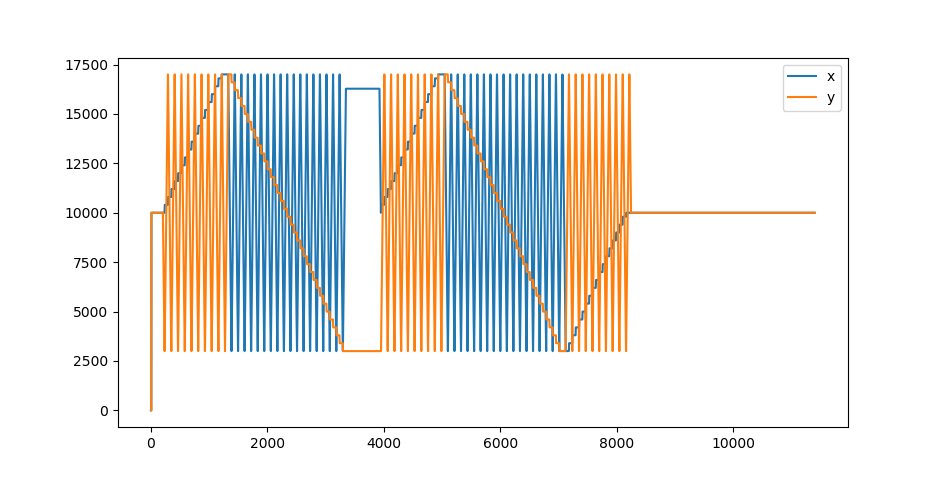

In [7]:
# Plot the x and y stage positions versus time
#%matplotlib inline
#plt.figure(figsize=(15,5))
plt.plot(t5,x_stage,label='x')
plt.plot(t5,y_stage,label='y')
plt.legend()
plt.show()

This scan pattern is just weird.  It looks like x moves over half its range in slow steps, with fast y scanning, then we switch to fast x scanning while y moves down slowly to the edge of its range, then y scans fast while x moves over the other part of the range.  It also looks like this pattern repeats not quite twice. 

<IPython.core.display.Javascript object>


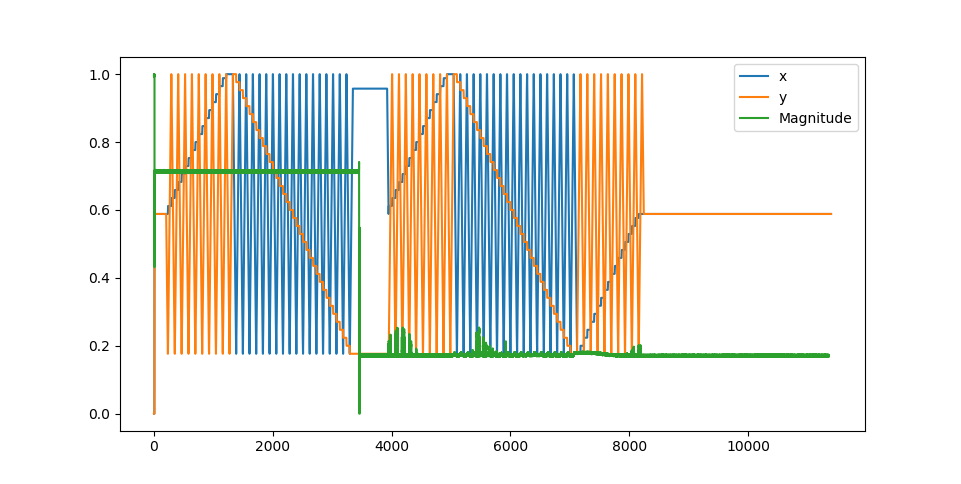

In [8]:
# Plot the signal on the x-y stage motions (channel 1)
#%matplotlib inline
#plt.figure(figsize=(15,5))
plt.plot(t5,x_stage/x_stage.max(),label='x')
plt.plot(t5,y_stage/y_stage.max(),label='y')
plt.plot(t488,mag/mag.max(),label='Magnitude')
plt.legend()
plt.show()

I don't see evidence for any signal in the first scan pattern.  There _is_ signal in the second, but as we'll see below, the pattern for when it appears doesn't make sense.

In [9]:
# I'm going to define the two chunks I see by hand (in seconds)
# This part is _super_ not general and very ugly
chunk1 = [180,3350]
chunk2 = [3940,8250]
# The +1 is for later definition, so that there's always a x/y stage position for any detector value
wh1_5 = np.logical_and(t5 > chunk1[0], t5 < chunk1[1])
wh1_488 = np.logical_and(t488 > chunk1[0]+1, t488 < chunk1[1]-1)
wh2_5 = np.logical_and(t5 > chunk2[0], t5 < chunk2[1])
wh2_488 = np.logical_and(t488 > chunk2[0]+1, t488 < chunk2[1]-1)

<IPython.core.display.Javascript object>


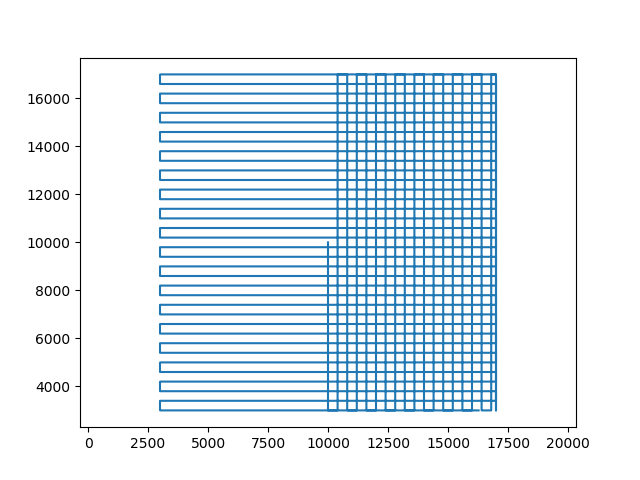

In [12]:
# Here's what it looks like plotted x versus y
#%matplotlib inline
#plt.figure(figsize=(10,10))
plt.plot(x_stage[wh1_5],y_stage[wh1_5])
plt.axis('equal')
plt.show()

<IPython.core.display.Javascript object>


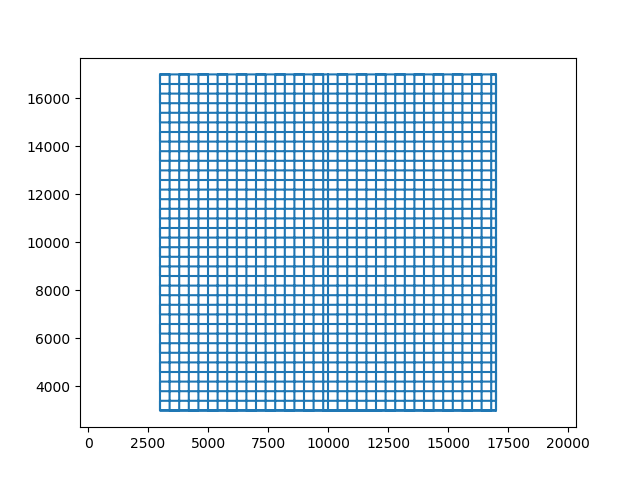

In [13]:
# Here's what it looks like plotted x versus y
#%matplotlib inline
#plt.figure(figsize=(10,10))
plt.plot(x_stage[wh2_5],y_stage[wh2_5])
plt.axis('equal')
plt.show()

In [14]:
# Let's focus on that second chunk
t_s2_5 = t5[wh2_5]
x_s2 = interp1d(t_s2_5, x_stage[wh2_5], kind='nearest')
y_s2 = interp1d(t_s2_5, y_stage[wh2_5], kind='nearest')

In [21]:
# Make a cut version of the data just during the good bit
t = t488[wh2_488]
m = mag[wh2_488]
p = phs[wh2_488]
x_s = x_s2(t)
y_s = y_s2(t)

<IPython.core.display.Javascript object>


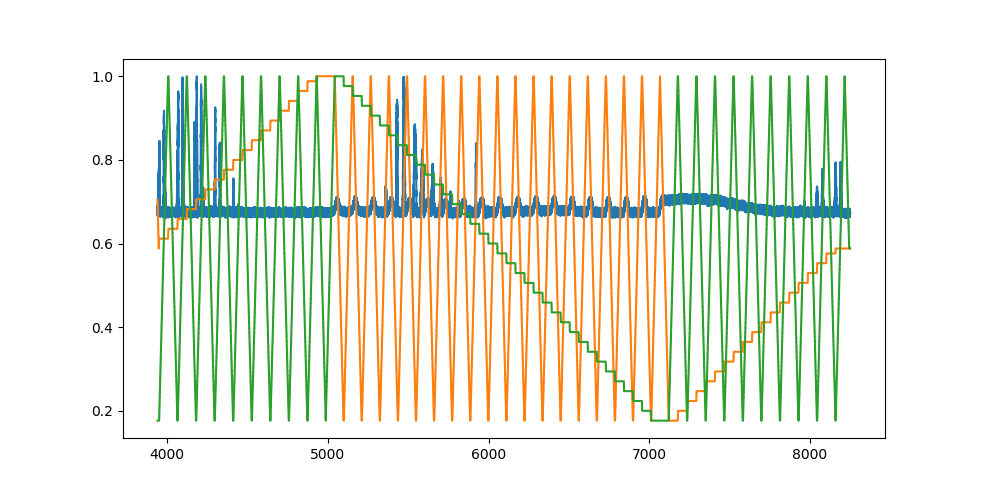

In [19]:
#%matplotlib inline
#plt.figure(figsize=(15,6))
plt.plot(t,m/m.max())
plt.plot(t,x_s/x_s.max())
plt.plot(t,y_s/y_s.max())
plt.show()

<IPython.core.display.Javascript object>


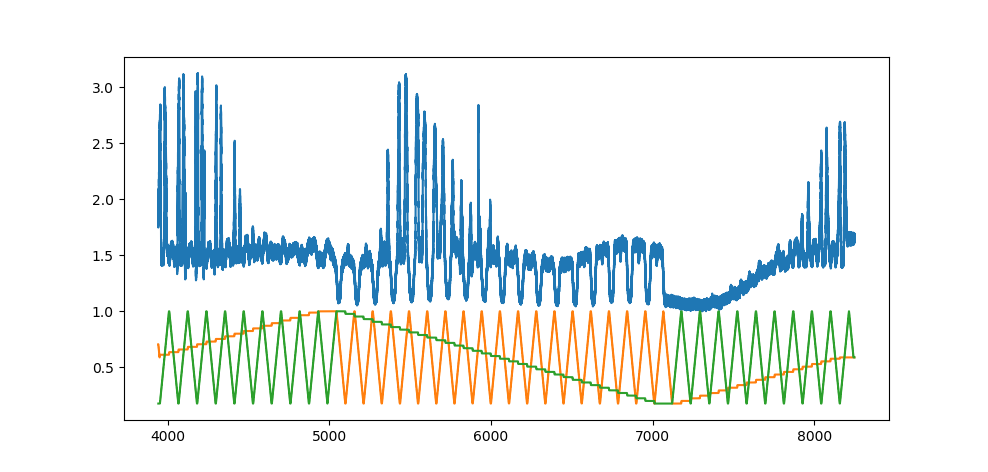

In [25]:
plt.plot(t,p/p.max())
plt.plot(t,x_s/x_s.max())
plt.plot(t,y_s/y_s.max())
plt.show()

In [24]:
plt.plot(x_s,y_s)
plt.show()

In [ ]:
# There's probably a better way to determine this based on the gradient in x,y 
# but it looks like the grid is about 250 x 250 in some units
ds = 100.
xpix = np.arange(x_s(t).min(),x_s(t).max(),ds)
ypix = np.arange(y_s(t).min(),y_s(t).max(),ds)

In [ ]:
#%%time
#zi = griddata((x_s(t), y_s(t)), m, (xpix[None,:], ypix[:,None]), method='nearest')

In [31]:
%%time
mag_map = binned_statistic_2d(x_s, y_s, m, 'mean',bins=30)#, bins=140)
phs_map = binned_statistic_2d(x_s, y_s, p, 'mean',bins=30)

CPU times: user 208 ms, sys: 49 ms, total: 257 ms
Wall time: 255 ms


<IPython.core.display.Javascript object>


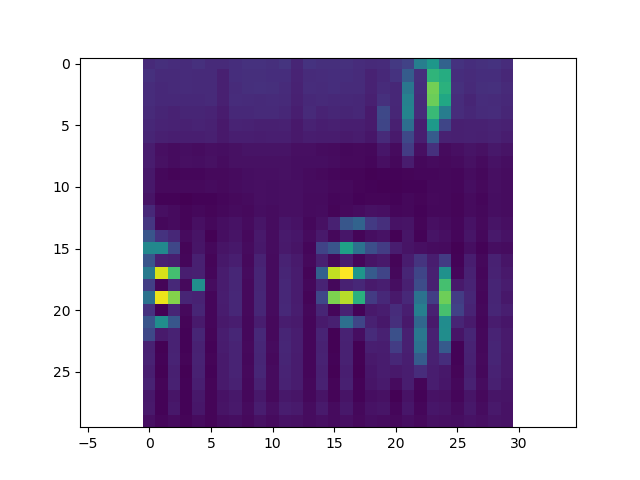

In [34]:
plt.imshow(mag_map.statistic,aspect='auto')
plt.axis('equal')
plt.show()

<IPython.core.display.Javascript object>


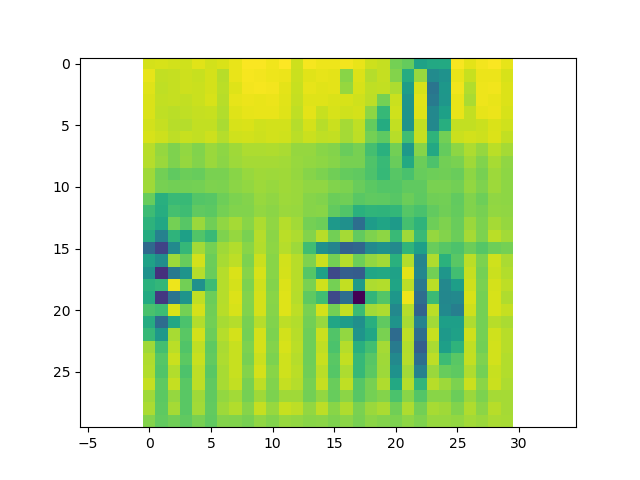

In [35]:
plt.imshow(phs_map.statistic,aspect='auto')
plt.axis('equal')
plt.show()

<IPython.core.display.Javascript object>


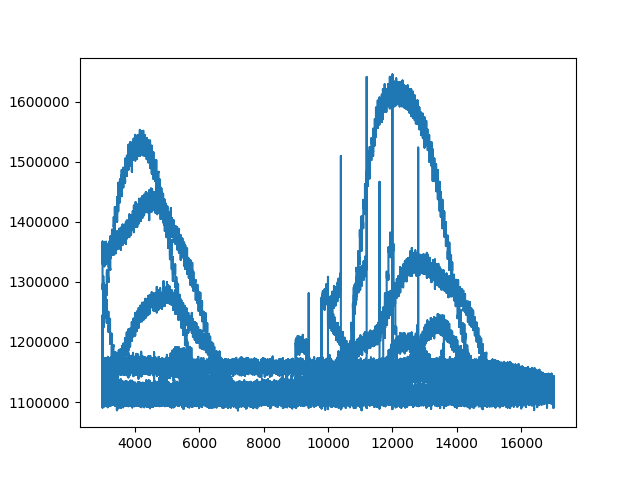

In [29]:
plt.plot(x_s,m)
plt.show()

<IPython.core.display.Javascript object>


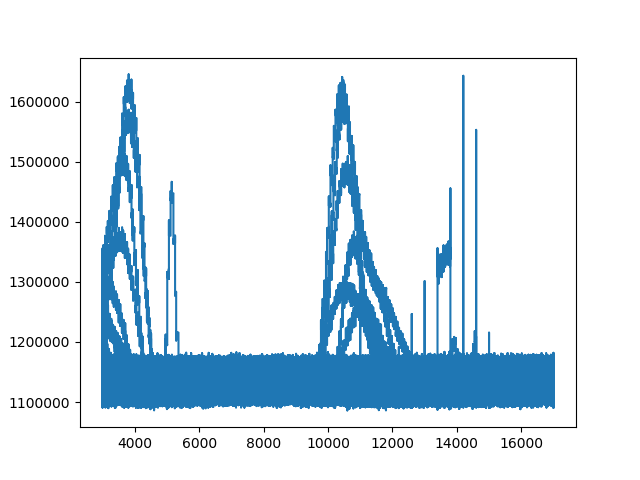

In [30]:
plt.plot(y_s,m)
plt.show()

The above two plots are probably the clearest statement of the problem: it looks like there are two different ranges of x and y for which the detector is responding.  If it's a single detector responding to a single light source, there should be only one ($x_0,y_0$) around which the detector responds.